# Backtest the Kelly strategy for robustness

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from util_kelly import simulate_kelly_strategy, backtest_kelly_strategy, generate_simulation_plots, simulation_boxplot

Here we want to backtest the Kelly Strategy from Notebook "03_analysis_kelly_strategy.ipynb" with parameters found to be near optimal. We will backtest against the historical S&P 500 data.

In [2]:
def optimized_kelly_strategy(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
    window=350, min_kelly=0, max_kelly=10, kelly_fraction=0.4)

Test the strategy ove a horizon of 1, 2, 10, 20, 30 and 40 business years respectivly. We run the strategy on 1000 randomly picked starting dates.

In [7]:
investment_horizon = [252,504,2520,5040,7560,10080]
summary_statistics = pd.DataFrame()
histories = [None for _ in range(len(investment_horizon))]

for i, horizon in enumerate(investment_horizon):
    history, statistics = backtest_kelly_strategy(optimized_kelly_strategy, number_repeats=2000, investment_horizon=horizon)
    summary_statistics[f"date_{i}"] = statistics['date']
    summary_statistics[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics[f"cum_returns_{i}"] = statistics['cum_returns']
    histories[i] = [hist[['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']] for hist in history]
    pd.to_pickle(histories[i], f'data/experiment_0/history_{i}.pkl')

pd.to_pickle(summary_statistics, 'data/experiment_0/summary_statistics.pkl')

For the mathematically inclined people among you, the summary statistics are printed below.

In [11]:
summary_statistics.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.014758,0.037517,0.031377,0.059831,0.399923,0.316594,0.949566,0.660730,1.465048,0.983342,2.100557,1.345440
std,0.001341,0.150900,0.087960,0.232829,0.689073,0.408620,0.975608,0.585411,1.154317,0.673932,1.340482,0.773211
min,0.007544,-0.832260,-1.110831,-1.325507,-1.116828,-0.879494,-1.115196,-0.998529,-0.850206,-0.671120,-0.842844,-0.716417
25%,0.013595,-0.049177,0.027111,-0.058995,-0.100233,0.016165,0.127056,0.223927,0.489224,0.453873,0.949269,0.658856
50%,0.013752,0.053371,0.027346,0.088770,0.190025,0.317814,0.849409,0.603462,1.556505,0.920580,2.469001,1.533938
75%,0.016129,0.135237,0.032219,0.222212,0.867752,0.632866,1.836573,1.151762,2.518385,1.467156,3.030356,2.009678
max,0.016581,0.605294,0.581973,0.695174,3.062222,1.224728,3.161031,2.042822,3.769914,2.694425,4.474303,2.799810


We can see that the Kelly strategy is expected to statistically outperform buy and hold after 20 years, since that is the first time the median cumulative return of the Kelly strategy beats Buy and Hold. We can also see that the risk of running the Kelly strategy is always significantly higher than Buy and Hold (much greater standard deviation).

Now for the visually inclined people the boxplot graphic below. The box shows the range of the 1st to 3rd quartile, the bracket shows the standard deviation the green dotted line shows the median and the orange line shows the mean. The circles outside the boxes represent outliers.

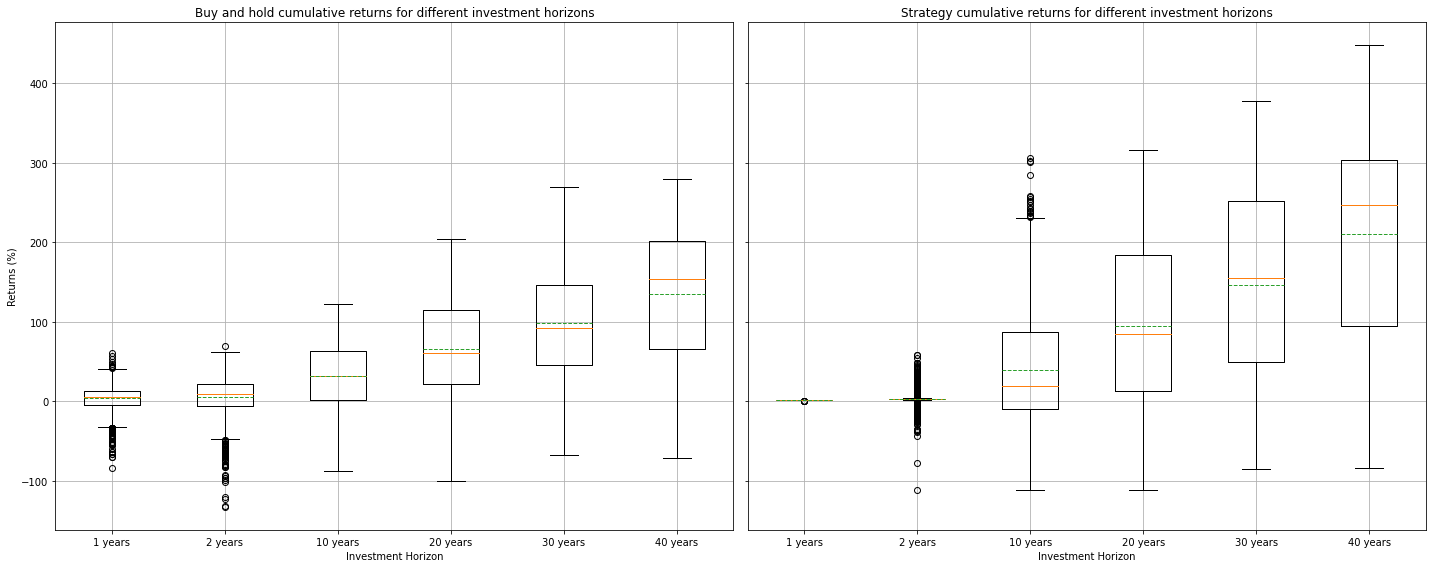

In [12]:
simulation_boxplot(summary_statistics, investment_horizon=investment_horizon, save_name='plots/cumulative_returns_optimized_strategy.png')

What can we learn about the relationship between entry date into the market and overall return? he resampling here only makes the visualisation easier.

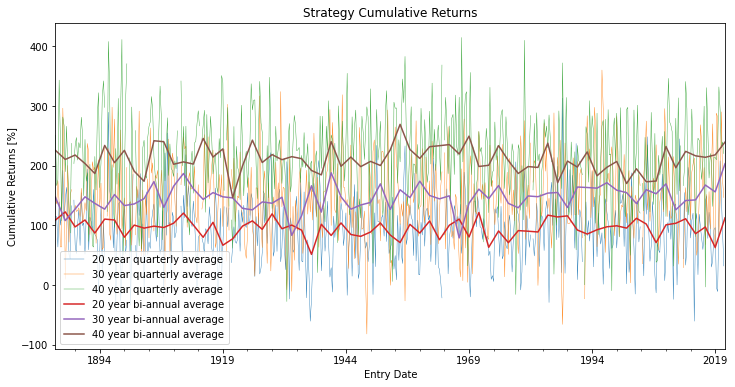

In [43]:
quarterly_data = summary_statistics.resample('BQ', on='date_0').mean() * 100
yearly_data = summary_statistics.resample('2BA', on='date_0').mean() * 100
fig, ax = plt.subplots(figsize=(12,6))
quarterly_data.plot(ax=ax, y=['strategy_cum_returns_3', 'strategy_cum_returns_4', 'strategy_cum_returns_5'], linewidth=0.4, label=['20 year quarterly average', '30 year quarterly average', '40 year quarterly average'], title='Strategy Cumulative Returns')
yearly_data.plot(ax=ax, y=['strategy_cum_returns_3', 'strategy_cum_returns_4', 'strategy_cum_returns_5'], kind='line', label=['20 year bi-annual average', '30 year bi-annual average', '40 year bi-annual average'])
ax.legend(loc='lower left')
ax.set_xlabel('Entry Date')
ax.set_ylabel('Cumulative Returns [%]')
plt.savefig('plots/cumulative_returns_by_entry_date.png')

The first thing to notice is that for longer times in the market, the accumulated returns are higher. This observation was already established in the box plot above. Another very important thing to notice is that the variance of strategy returns is actually homogeneously distributed with respect to entry date as opposed to drifting in time!

And now for good measure, I show you some of the simulation runs for the 20 year investment horizon.

In [44]:
history = histories[3] # 20 year simulation
max_samples = 100
generate_simulation_plots(history, max_samples=max_samples, filename="horizon_20y")

In [45]:
!convert -delay 66 -loop 10 plots/tmp/horizon_20y*.png plots/horizon_20y.gif

![SegmentLocal](plots/horizon_20y.gif)

Consider a strategy with smaller estimation window size and less aggressive kelly sizing.

In [10]:
def kelly_strategy_1(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
    window=252, min_kelly=0, max_kelly=10, kelly_fraction=0.3)

investment_horizon_1 = [252,504,2520,5040,7560,10080]
summary_statistics_1 = pd.DataFrame()
histories_1 = [None for _ in range(len(investment_horizon_1))]
for i, horizon in enumerate(investment_horizon_1):
    history, statistics = backtest_kelly_strategy(kelly_strategy_1, number_repeats=2000, investment_horizon=horizon)
    summary_statistics_1[f"date_{i}"] = statistics['date']
    summary_statistics_1[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_1[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_1[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_1[i], f'data/experiment_1/history_{i}.pkl')

pd.to_pickle(summary_statistics_1, 'data/experiment_1/summary_statistics.pkl')

In [11]:
summary_statistics_1.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.014803,0.028921,0.056794,0.064278,0.542489,0.324999,1.209189,0.662272,1.960149,1.031182,2.695012,1.360055
std,0.001372,0.151670,0.155704,0.227769,0.599992,0.414358,0.898286,0.571687,0.968163,0.689010,1.020328,0.784428
min,0.007465,-0.903598,-0.778193,-1.362647,-0.563023,-0.963838,-0.859306,-1.014225,0.156775,-0.627459,0.661064,-0.716417
25%,0.013595,-0.052537,-0.001800,-0.059923,0.082258,0.011512,0.474650,0.230596,1.043143,0.474557,1.874919,0.658223
50%,0.014773,0.049182,0.031065,0.090312,0.430271,0.330042,1.136804,0.603972,1.893146,1.006584,2.870348,1.543464
75%,0.016188,0.124729,0.097566,0.223058,0.955690,0.662322,1.945542,1.133351,2.880739,1.525240,3.488412,2.020517
max,0.016581,0.558162,0.765970,0.792748,2.729342,1.275383,3.481645,2.006828,3.815649,2.687763,4.576731,2.809779


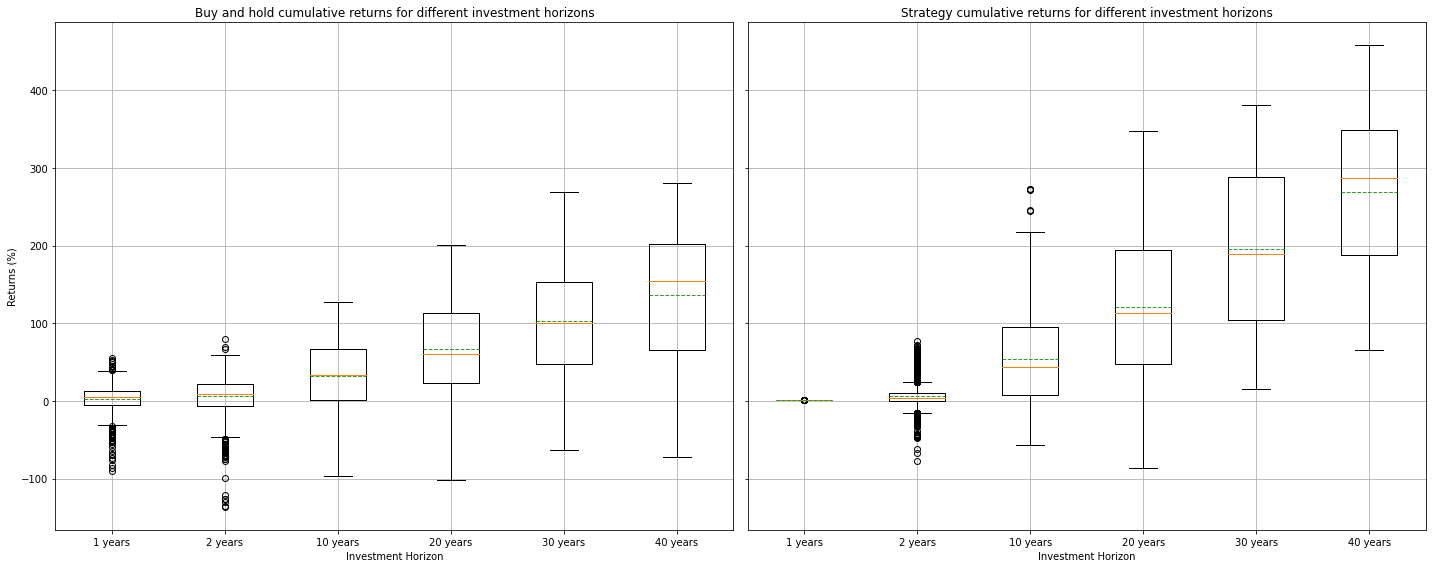

In [12]:
simulation_boxplot(summary_statistics_1, investment_horizon=investment_horizon_1, save_name='plots/cumulative_returns_strategy_1.png')

This strategy the same shorter window, but a bigger Kelly sizing, taking on more risk.

In [13]:
def kelly_strategy_2(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
    window=252, min_kelly=0, max_kelly=10, kelly_fraction=0.5)

investment_horizon_2 = [252,504,2520,5040,7560,10080]
summary_statistics_2 = pd.DataFrame()
histories_2 = [None for _ in range(len(investment_horizon_2))]
for i, horizon in enumerate(investment_horizon_2):
    history, statistics = backtest_kelly_strategy(kelly_strategy_2, number_repeats=2000, investment_horizon=horizon)
    summary_statistics_2[f"date_{i}"] = statistics['date']
    summary_statistics_2[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_2[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_2[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_2[i], f'data/experiment_2/history_{i}.pkl')

pd.to_pickle(summary_statistics_2, 'data/experiment_2/summary_statistics.pkl')

In [14]:
summary_statistics_2.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.014732,0.031359,0.058645,0.068837,0.623616,0.317259,1.474603,0.665651,2.362360,1.004292,3.301341,1.353566
std,0.001395,0.154151,0.261284,0.220425,0.927754,0.416258,1.421469,0.586079,1.478995,0.694640,1.652949,0.763983
min,0.007544,-0.849198,-1.624860,-1.402601,-1.204314,-0.873494,-1.871199,-0.983769,-0.282258,-0.596909,-0.190105,-0.716417
25%,0.013595,-0.047972,-0.039387,-0.054940,-0.059782,0.011928,0.323191,0.233694,0.988259,0.449013,2.030775,0.665105
50%,0.013752,0.049991,0.030351,0.090709,0.439841,0.319599,1.241175,0.606165,2.331272,0.976221,3.504523,1.515591
75%,0.016188,0.131029,0.139518,0.218034,1.293253,0.653718,2.727571,1.140351,3.666277,1.503976,4.631953,2.008104
max,0.016581,0.530005,1.181609,0.683172,3.705762,1.275383,5.062019,2.030003,5.255894,2.696645,6.149507,2.737836


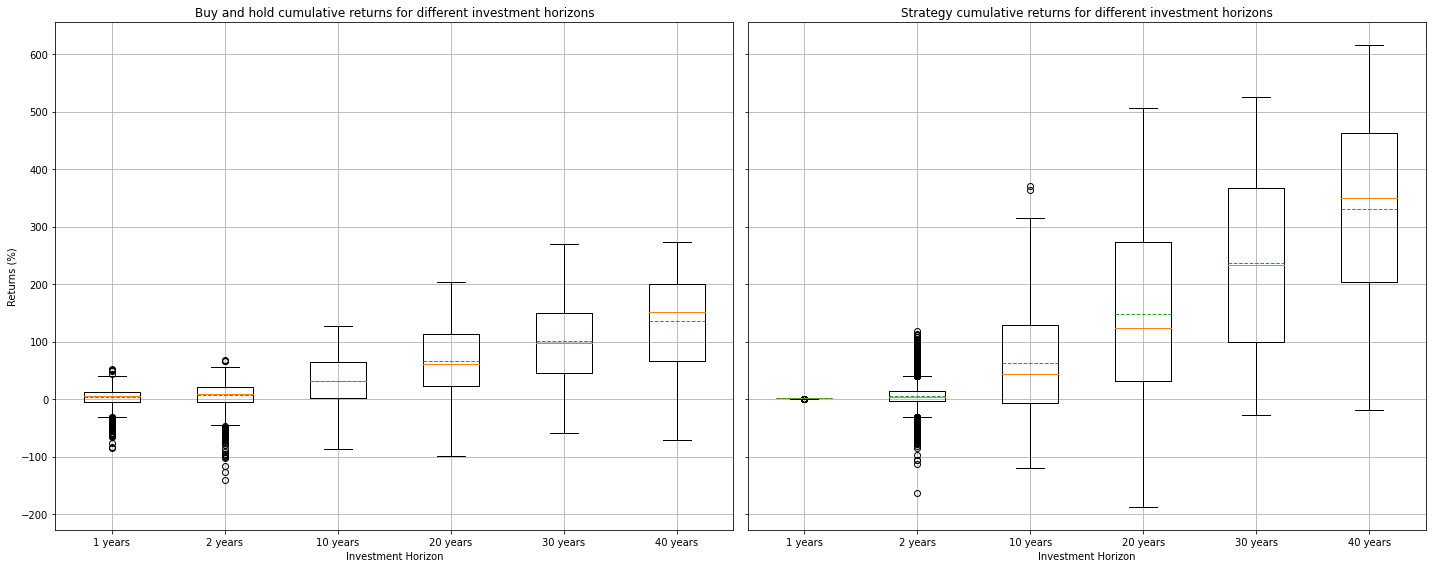

In [15]:
simulation_boxplot(summary_statistics_2, investment_horizon=investment_horizon_2, save_name='plots/cumulative_returns_strategy_2.png')

This strategy shortens the estimation window considerably, with a less aggressive Kelly sizing.

In [16]:
def kelly_strategy_3(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=90, min_kelly=0, max_kelly=10, kelly_fraction=0.3)

investment_horizon_3 = [252,504,2520,5040,7560,10080]
summary_statistics_3 = pd.DataFrame()
histories_3 = [None for _ in range(len(investment_horizon_3))]
for i, horizon in enumerate(investment_horizon_3):
    history, statistics = backtest_kelly_strategy(kelly_strategy_3, number_repeats=2000, investment_horizon=horizon)
    summary_statistics_3[f"date_{i}"] = statistics['date']
    summary_statistics_3[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_3[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_3[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_3[i], f'data/experiment_3/history_{i}.pkl')

pd.to_pickle(summary_statistics_3, 'data/experiment_3/summary_statistics.pkl')

In [17]:
summary_statistics_3.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.034871,0.034614,0.100411,0.070735,0.591266,0.319844,1.251157,0.664792,1.946442,1.007795,2.672039,1.347133
std,0.153244,0.150315,0.271763,0.217293,0.600760,0.412599,0.783073,0.574156,0.885273,0.686377,0.997623,0.772544
min,-0.431440,-0.846719,-0.848487,-1.127618,-0.642722,-0.939944,-0.493072,-1.012278,0.168803,-0.667829,0.953889,-0.596909
25%,-0.053502,-0.052286,-0.088809,-0.056033,0.143753,0.004749,0.666678,0.241476,1.356658,0.447071,1.932468,0.633806
50%,0.013477,0.054765,0.040303,0.091726,0.481898,0.315765,1.178816,0.602166,1.725486,0.958421,2.533889,1.519209
75%,0.098502,0.129574,0.259558,0.221339,1.011337,0.650105,1.775799,1.138085,2.445335,1.496036,3.214599,2.020228
max,0.661288,0.493343,1.096987,0.667640,2.395788,1.239011,3.713143,1.997133,4.313381,2.699160,4.998853,2.832103


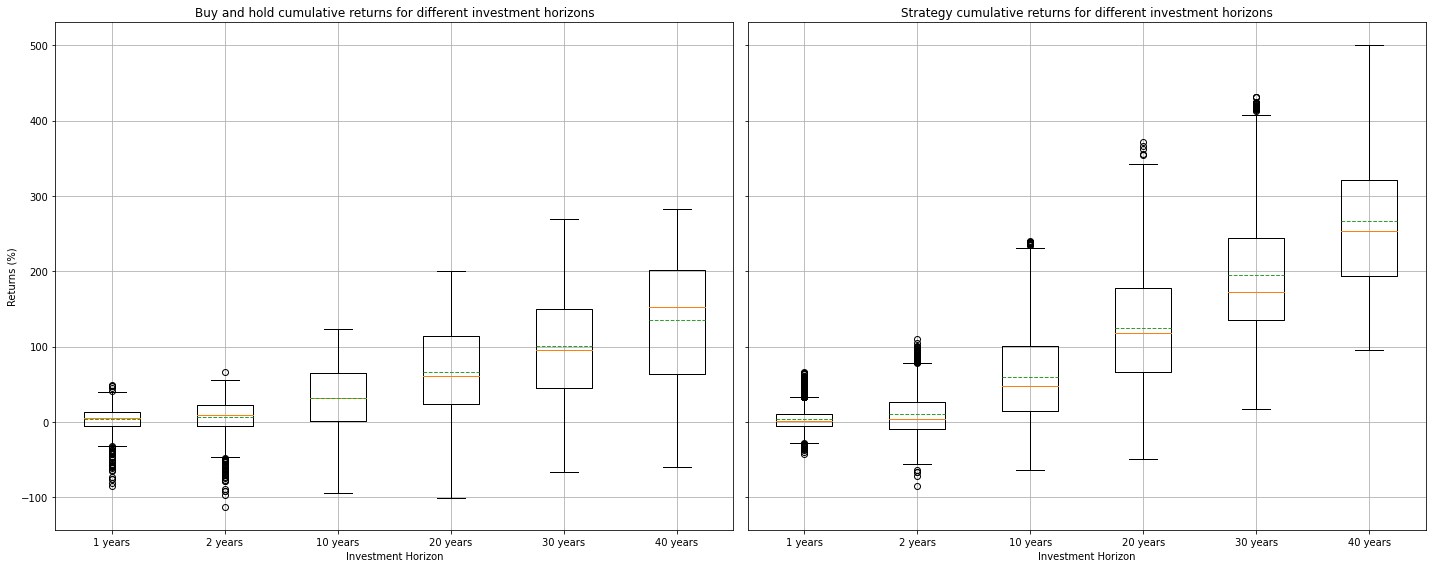

In [18]:
simulation_boxplot(summary_statistics_3, investment_horizon=investment_horizon_3, save_name='plots/cumulative_returns_strategy_3.png')

Even shorter estimation window, Kelly sizing same as above.

In [32]:
def kelly_strategy_4(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=60, min_kelly=0, max_kelly=10, kelly_fraction=0.3)

investment_horizon_4 = [252,504,2520,5040,7560,10080]
summary_statistics_4 = pd.DataFrame()
histories_4 = [None for _ in range(len(investment_horizon_4))]
for i, horizon in enumerate(investment_horizon_4):
    history, statistics = backtest_kelly_strategy(kelly_strategy_4, number_repeats=2000, investment_horizon=horizon)
    summary_statistics_4[f"date_{i}"] = statistics['date']
    summary_statistics_4[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_4[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_4[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_4[i], f'data/experiment_4/history_{i}.pkl')

pd.to_pickle(summary_statistics_4, 'data/experiment_4/summary_statistics.pkl')

In [33]:
summary_statistics_4.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.051931,0.030752,0.135002,0.067325,0.731795,0.337773,1.529648,0.662816,2.328048,1.015225,3.141476,1.331829
std,0.175456,0.151934,0.282522,0.220967,0.529483,0.421527,0.639951,0.575127,0.744704,0.671561,0.799074,0.782066
min,-0.490630,-0.946696,-0.587826,-1.355998,-0.466817,-1.042654,-0.131599,-0.983992,0.197266,-0.700999,1.046653,-0.716417
25%,-0.058789,-0.051982,-0.076797,-0.048438,0.350268,0.024904,1.037106,0.238155,1.859548,0.474531,2.579684,0.633163
50%,0.010433,0.049211,0.093117,0.088902,0.719478,0.347053,1.479804,0.586904,2.402293,0.995158,3.335738,1.506353
75%,0.134221,0.122392,0.306838,0.213863,1.104232,0.679167,2.018007,1.147414,2.935632,1.500213,3.752623,2.020172
max,0.836106,0.542156,1.088028,0.745370,2.376284,1.262767,3.132176,2.011293,3.767147,2.699160,4.437184,2.845620


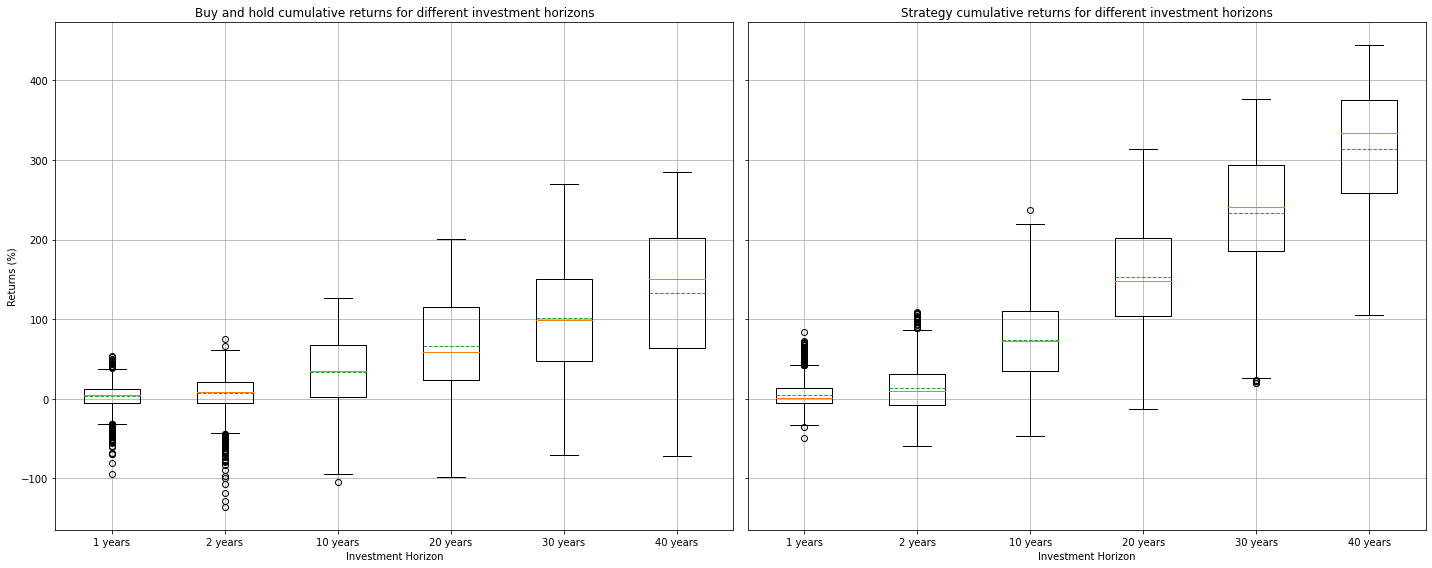

In [34]:
simulation_boxplot(summary_statistics_4, investment_horizon=investment_horizon_4, save_name='plots/cumulative_returns_strategy_4.png')

Even shorter estimation window, Kelly sizing same as above.

In [35]:
def kelly_strategy_5(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=30, min_kelly=0, max_kelly=10, kelly_fraction=0.3)

investment_horizon_5 = [252,504,2520,5040,7560,10080]
summary_statistics_5 = pd.DataFrame()
histories_5 = [None for _ in range(len(investment_horizon_5))]
for i, horizon in enumerate(investment_horizon_4):
    history, statistics = backtest_kelly_strategy(kelly_strategy_5, number_repeats=2000, investment_horizon=horizon)
    summary_statistics_5[f"date_{i}"] = statistics['date']
    summary_statistics_5[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_5[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_5[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_5[i], f'data/experiment_5/history_{i}.pkl')

pd.to_pickle(summary_statistics_5, 'data/experiment_5/summary_statistics.pkl')

In [36]:
summary_statistics_5.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.068990,0.036746,0.170308,0.076359,0.838289,0.322755,1.667547,0.663597,2.695480,0.962214,3.564097,1.342861
std,0.210594,0.146065,0.304218,0.213285,0.643012,0.427646,0.958926,0.576860,1.116756,0.667701,1.283181,0.768334
min,-0.485128,-0.849428,-0.794340,-1.019296,-0.747652,-0.910112,-0.934027,-1.012278,-0.548856,-0.686473,0.030638,-0.406035
25%,-0.073331,-0.051394,-0.029856,-0.047129,0.306180,-0.001093,0.985926,0.228201,2.235822,0.427405,3.133628,0.638935
50%,0.042346,0.053107,0.147837,0.100958,0.872059,0.334340,1.833035,0.603493,2.933823,0.889959,3.894518,1.538787
75%,0.188557,0.131586,0.361083,0.221633,1.291178,0.665172,2.331822,1.133372,3.435960,1.463978,4.511359,2.006897
max,0.960527,0.567020,1.820596,0.695174,2.505620,1.203315,3.908830,2.035952,4.487229,2.701678,5.361501,2.768538


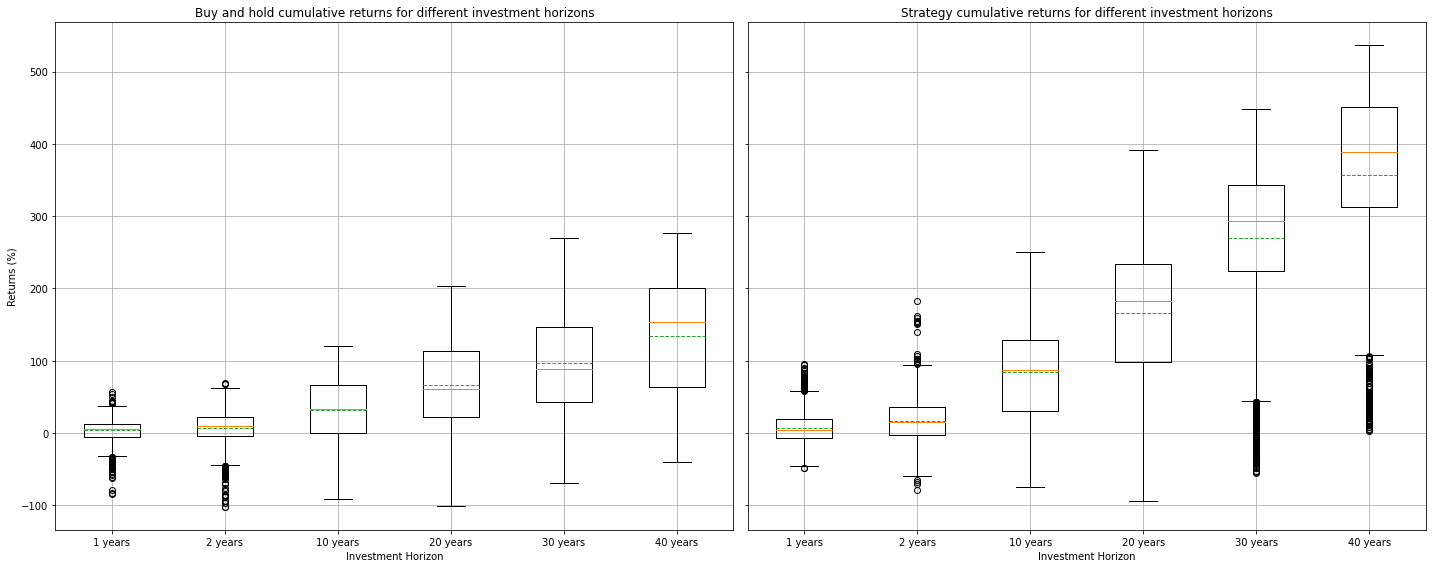

In [37]:
simulation_boxplot(summary_statistics_5, investment_horizon=investment_horizon_5, save_name='plots/cumulative_returns_strategy_5.png')

Compare the different strategies with respect to the same investment horizon.

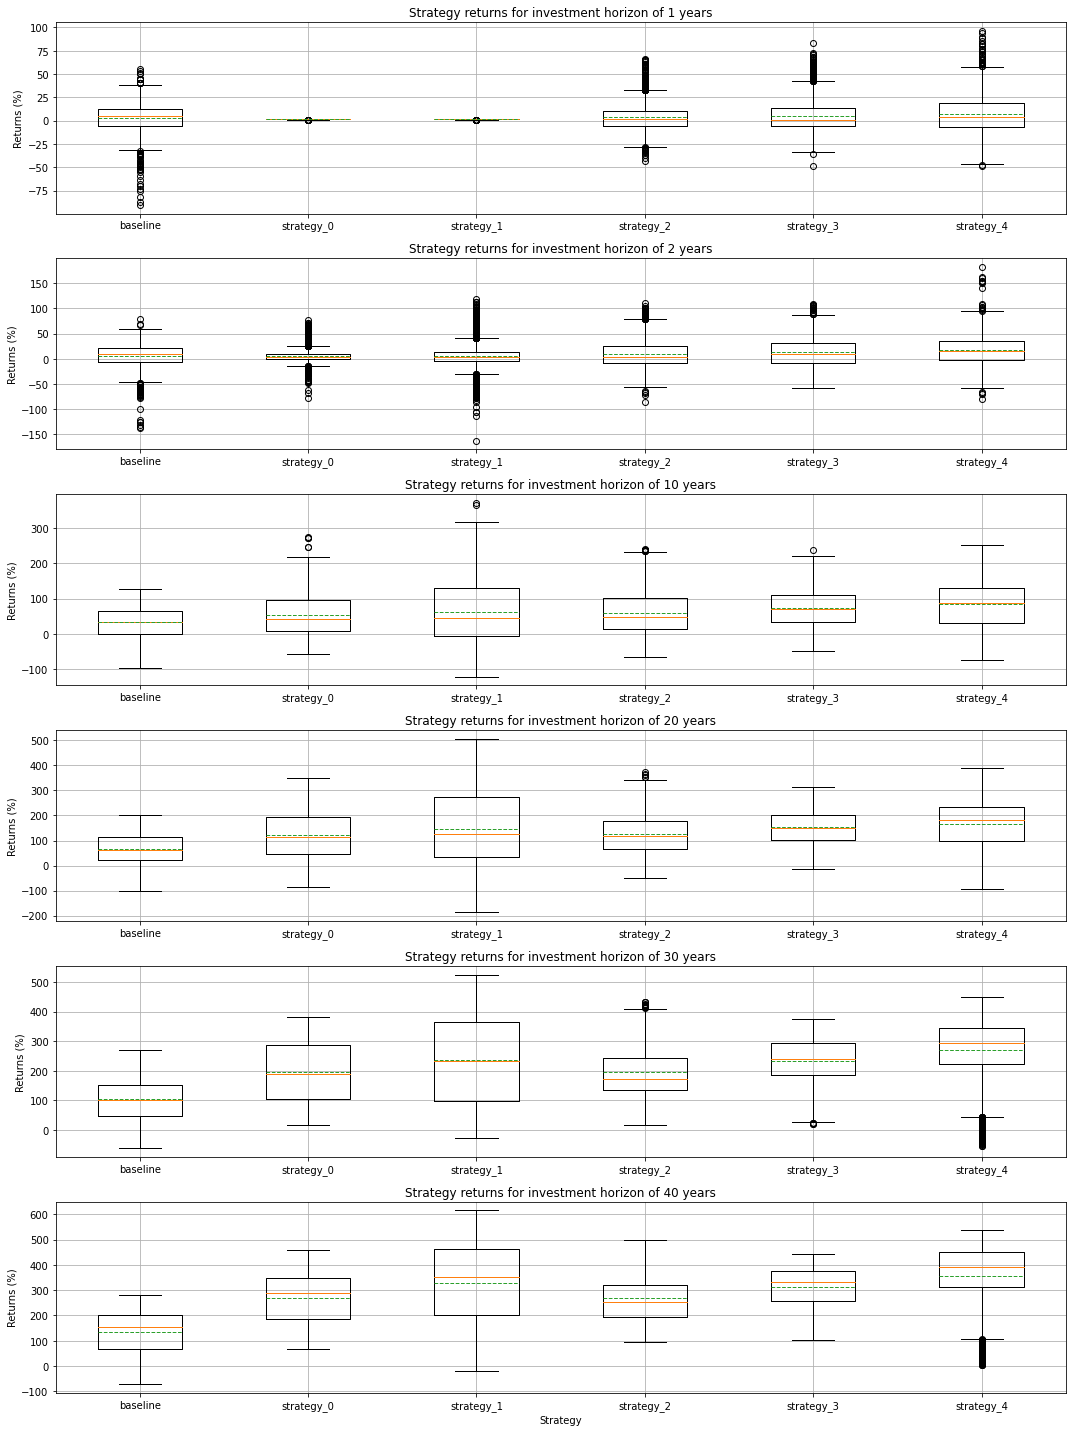

In [40]:
investment_horizon = [252,504,2520,5040,7560,10080]
strategies = [summary_statistics_1, summary_statistics_2, summary_statistics_3, summary_statistics_4, summary_statistics_5]
strategy_returns = pd.DataFrame()
fig, ax = plt.subplots(6,figsize=(15, 20))

for i, horizon in enumerate(investment_horizon):
    strategy_returns['baseline'] = strategies[0][f"cum_returns_{i}"] * 100
    for j, strategy in enumerate(strategies):
        strategy_returns[f"strategy_{j}"] = strategy[f"strategy_cum_returns_{i}"] * 100
    ax[i].boxplot(strategy_returns, showfliers=True, showmeans=True, meanline=True, widths=0.5, labels=strategy_returns.columns)
    ax[i].set_ylabel('Returns (%)')
    ax[i].set_title(f"Strategy returns for investment horizon of {horizon//252} years")
    ax[i].grid(True)
ax[len(investment_horizon)-1].set_xlabel('Strategy')
plt.tight_layout()
plt.savefig("plots/strategy_comparison.png")
plt.show()

With all these comparisons you can easily draw you own conclusions